In [1]:
import os
import random
from glob import glob
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from PIL import Image
from sklearn import decomposition
from torch.utils.data import DataLoader, Dataset
from torchvision import io
from torchvision.transforms.v2 import functional as F
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModel

## Data Exploration:

In [2]:
# Set images path
train_path = Path("../data/BrainTumor/train")
test_path = Path("../data/BrainTumor/test")
valid_path = Path("../data/BrainTumor/valid")

# Setup class names
CLASSES_NAMES = ["glioma", "meningioma", "pituitary"]

# Define datasets
datasets = {"Train": train_path, "Test": test_path, "Validation": valid_path}

In [ ]:
# Analyze directories
def analyze_dataset_directory(directory: Path, file_type: str = "images") -> None:
    subdirectory = directory / file_type
    files = (
        list(subdirectory.glob("*.jpg")) + list(subdirectory.glob("*.png"))
        if file_type == "images"
        else list(subdirectory.glob("*.txt"))
    )
    counter = []

    if file_type == "images":
        for file in files:
            with Image.open(file) as img:
                counter.append(img.size)
        print(f"Images in {directory.name}: {len(files)}, Different sizes: {set(counter)}")

    elif file_type == "labels":
        for file in files:
            with open(file, "r") as f:
                labels = f.readlines()
            counter.append(len(labels))
        print(f"Labels in {directory.name}: {len(files)}, Labels per file: {set(counter)}")


for dataset_name, path in datasets.items():
    print(f"\n{dataset_name} Dataset:")
    analyze_dataset_directory(path, "images")
    analyze_dataset_directory(path, "labels")


Train Dataset:
Images in images: 2144, Different sizes: {(640, 640)}
Labels in labels: 2144, Labels per file: {1}

Test Dataset:
Images in images: 308, Different sizes: {(640, 640)}
Labels in labels: 308, Labels per file: {1}

Validation Dataset:
Images in images: 612, Different sizes: {(640, 640)}
Labels in labels: 612, Labels per file: {1}


In [ ]:
# Check that all images are labeled
def image_has_label(directory: Path) -> None:
    images_path = directory / "images"
    labels_path = directory / "labels"

    for image_path in images_path.glob("*.jpg"):
        label_file = labels_path / f"{image_path.stem}.txt"
        if not label_file.exists():
            print(f"Image {image_path} does not have a corresponding label file.")

    print(f"All images in {images_path} have corresponding label files in {labels_path}")


for dataset_name, path in datasets.items():
    print(f"\n{dataset_name} Dataset:")
    image_has_label(path)


Train Dataset:
All images in ../data/BrainTumor/train/images have corresponding label files in ../data/BrainTumor/train/labels

Test Dataset:
All images in ../data/BrainTumor/test/images have corresponding label files in ../data/BrainTumor/test/labels

Validation Dataset:
All images in ../data/BrainTumor/valid/images have corresponding label files in ../data/BrainTumor/valid/labels


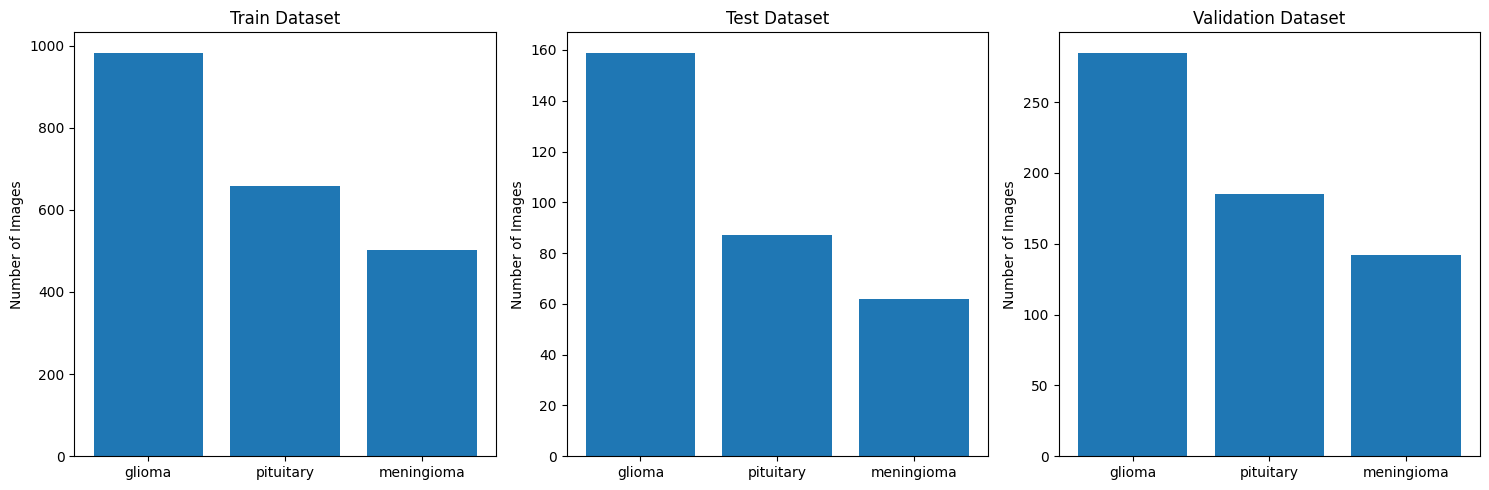

In [5]:
# Explore classes and coordinates
def get_image_label_info(labels_file: Path) -> Tuple[str, List[float]]:
    with open(labels_file, "r") as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        entries = line.strip().split()
        # Extract class id (first entry)
        class_id = int(entries[0])

        # Coordinates are in pairs: x1, y1, x2, y2, ..., xn, yn
        coordinates = [float(i) for i in entries[1:]]
        x_coords = coordinates[::2]
        y_coords = coordinates[1::2]

        # Get bounding box from polygon
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        # Convert to center format
        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        labels.append(
            {"class_id": class_id, "bbox": [cx, cy, width, height], "vertices": list(zip(x_coords, y_coords))}
        )

    return labels


def explore_classes_and_polygon_coordinates(labels_folder: Path) -> Tuple[Dict[str, str], Dict[str, List[float]]]:
    classes = {}
    coordinates = {}

    for labels_file in labels_folder.glob("*.txt"):
        labels = get_image_label_info(labels_file)
        classes[labels_file.stem] = CLASSES_NAMES[labels[0]["class_id"]]
        coordinates[labels_file.stem] = labels[0]["vertices"]

    return classes, coordinates


# Plot all three class distributions
def plot_class_distribution(train_classes: dict, test_classes: dict, valid_classes: dict) -> None:
    plt.figure(figsize=(15, 5))

    dataset_names = ["Train", "Test", "Validation"]

    for i, dct in enumerate([train_classes, test_classes, valid_classes]):
        class_counts = {}
        for class_name in dct.values():
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        # Order classes by frequency
        class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

        plt.subplot(1, 3, i + 1)
        plt.bar(class_counts.keys(), class_counts.values())
        plt.ylabel("Number of Images")
        plt.title(f"{dataset_names[i]} Dataset")

    plt.tight_layout()
    plt.show()


train_classes, train_coordinates = explore_classes_and_polygon_coordinates(train_path / "labels")
test_classes, test_coordinates = explore_classes_and_polygon_coordinates(test_path / "labels")
valid_classes, valid_coordinates = explore_classes_and_polygon_coordinates(valid_path / "labels")
plot_class_distribution(train_classes, test_classes, valid_classes)

Image: 991_jpg.rf.f6a2eca84e699dbd0b5270def9f19ff0
First label Class: pituitary, ID: 2
Image size: 640 x 640
First label number of polygon vertices: 10
First label raw coordinates: [(0.3509749296875, 0.48189415), (0.3454039, 0.5431754875), (0.373259053125, 0.5654596093750001), (0.4206128140625, 0.57381615625), (0.4484679671875, 0.540389971875), (0.45403899687499993, 0.47632312031249996), (0.42618384374999996, 0.4484679671875), (0.3816155984375, 0.4484679671875), (0.3621169921875, 0.4568245125), (0.3509749296875, 0.48189415)]


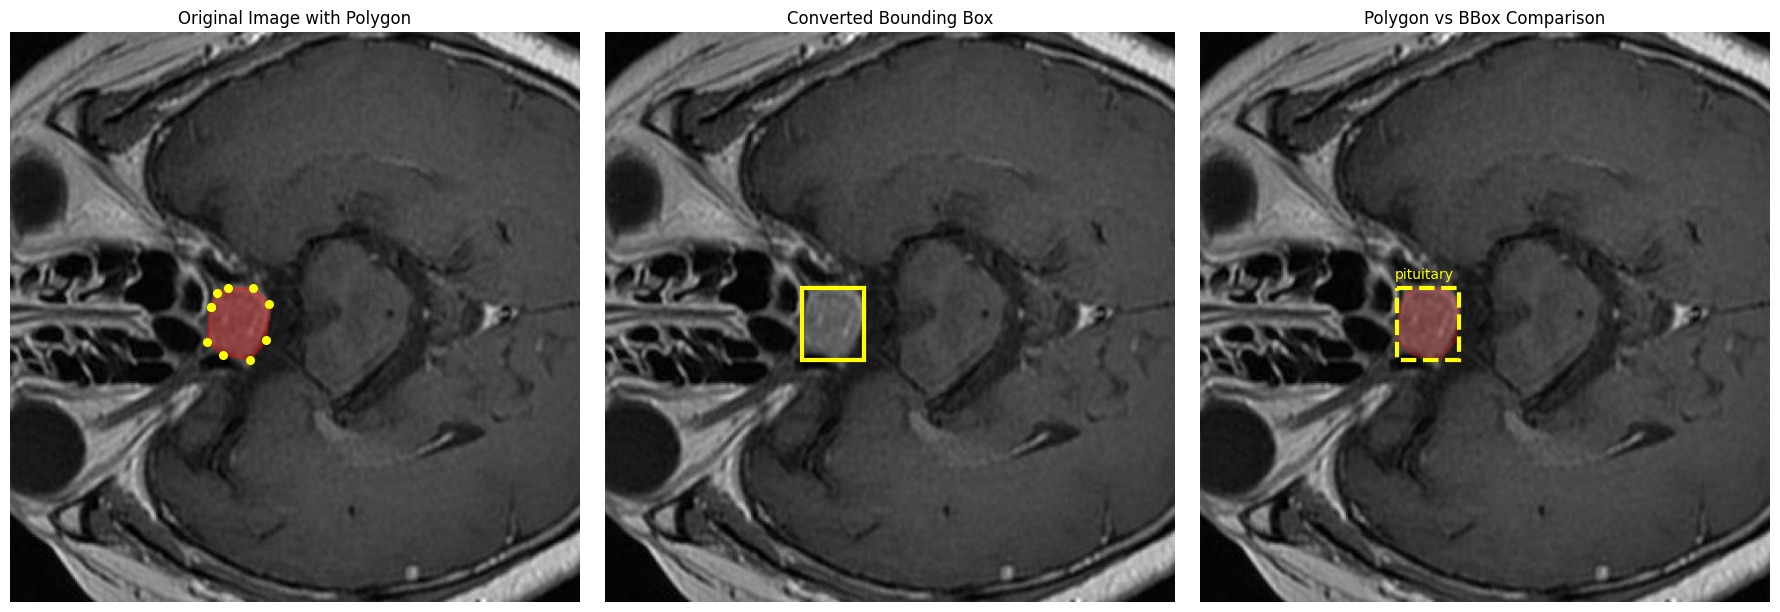

In [ ]:
def visualize_polygon_vs_bbox(image_name: str) -> None:
    # Load image and label
    image = io.read_image(f"../data/BrainTumor/train/images/{image_name}.jpg")
    label_file = f"../data/BrainTumor/train/labels/{image_name}.txt"

    labels = get_image_label_info(label_file)
    first_class_id, first_vertices = labels[0]["class_id"], labels[0]["vertices"]
    h, w = F.get_size(image)

    print(f"Image: {image_name}")
    print(f"First label Class: {CLASSES_NAMES[first_class_id]}, ID: {first_class_id}")
    print(f"Image size: {w} x {h}")
    print(f"First label number of polygon vertices: {len(first_vertices)}")
    print(f"First label raw coordinates: {first_vertices[:10]}")

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original image with polygon overlay
    ax1 = axes[0]
    ax1.imshow(image.permute(1, 2, 0).numpy())
    ax1.set_title("Original Image with Polygon")
    ax1.axis("off")

    # 2. Converted bounding box
    ax2 = axes[1]
    ax2.imshow(image.permute(1, 2, 0).numpy())
    ax2.set_title("Converted Bounding Box")
    ax2.axis("off")

    # 3. Comparison overlay
    ax3 = axes[2]
    ax3.imshow(image.permute(1, 2, 0).numpy())
    ax3.set_title("Polygon vs BBox Comparison")
    ax3.axis("off")

    for label in labels:
        class_id, bbox, vertices = label["class_id"], label["bbox"], label["vertices"]

        # Scale coordinates to image size
        x_coords = [vertice[0] * w for vertice in vertices]
        y_coords = [vertice[1] * h for vertice in vertices]

        # Create polygon patch
        polygon_points = list(zip(x_coords, y_coords))
        polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.3, closed=True)
        ax1.add_patch(polygon)

        # Mark vertices
        ax1.scatter(x_coords, y_coords, color="yellow", s=30, zorder=5)

        # Scale to image size
        cx, cy, bw, bh = bbox
        cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h

        # Convert to corner format for visualization
        x_min_scaled = cx - bw / 2
        y_min_scaled = cy - bh / 2

        # Draw bounding box
        rect = patches.Rectangle(
            (x_min_scaled, y_min_scaled), bw, bh, linewidth=3, edgecolor="yellow", facecolor="none"
        )
        ax2.add_patch(rect)

        # Draw both polygon and bounding box
        polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True)
        ax3.add_patch(polygon)

        # Add class name tag to bounding box
        ax3.text(
            x_min_scaled + 30, y_min_scaled - 10, CLASSES_NAMES[class_id], color="yellow", fontsize=10, ha="center"
        )
        rect = patches.Rectangle(
            (x_min_scaled, y_min_scaled),
            bw,
            bh,
            linewidth=3,
            edgecolor="yellow",
            facecolor="none",
            linestyle="--",
        )
        ax3.add_patch(rect)

    plt.tight_layout()
    plt.show()


# Run the visualization
train_images_path = train_path / "images"
train_images = list(train_images_path.glob("*.jpg"))
sample = random.choice(train_images)
image_name = sample.stem

visualize_polygon_vs_bbox(image_name)

## Model Summary:

In [11]:
# Load Dinov2 model and transformer
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True)
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base")

torchinfo.summary(
    dinov2,
    input_data=torch.randn(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3,
    row_settings=["var_names"],
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
Dinov2Model (Dinov2Model)                                    [1, 3, 224, 224]          [1, 768]                  --                        True
├─Dinov2Embeddings (embeddings)                              [1, 3, 224, 224]          [1, 257, 768]             1,053,696                 True
│    └─Dinov2PatchEmbeddings (patch_embeddings)              [1, 3, 224, 224]          [1, 256, 768]             --                        True
│    │    └─Conv2d (projection)                              [1, 3, 224, 224]          [1, 768, 16, 16]          452,352                   True
│    └─Dropout (dropout)                                     [1, 257, 768]             [1, 257, 768]             --                        --
├─Dinov2Encoder (encoder)                                    [1, 257, 768]             [1, 257, 768]             --                  

## Feature Extraction Visualization:

In [12]:
# Set random seed
random.seed(5)

# Number of images to select
num_images = 5

# Get n random image paths
img_dir = "../data/BrainTumor/train/images"
img_paths = glob(os.path.join(img_dir, "*.jpg"))
selected_imgs = random.sample(img_paths, num_images)

# Load images
images = [Image.open(p) for p in selected_imgs]

# Preprocess images
inputs = processor(images=images, return_tensors="pt")

# Extract patch embeddings for all images
dinov2.eval()
with torch.no_grad():
    outputs = dinov2(**inputs)
    feature_maps = outputs.last_hidden_state[:, 1:, :]

# Stack all patches from all images
batch_size, num_patches, embed_dim = feature_maps.shape
all_patches = feature_maps.reshape(-1, embed_dim)

print(f"Feature maps shape: {feature_maps.shape} [batch_size, num_patches, embed_dim]")
print(f"All patches shape: {all_patches.shape} [batch_size*num_patches, embed_dim]")

Feature maps shape: torch.Size([5, 256, 768]) [batch_size, num_patches, embed_dim]
All patches shape: torch.Size([1280, 768]) [batch_size*num_patches, embed_dim]


PCA explained variance ratio: [0.11963072 0.09923572 0.08758808]
Total variance explained: 0.306


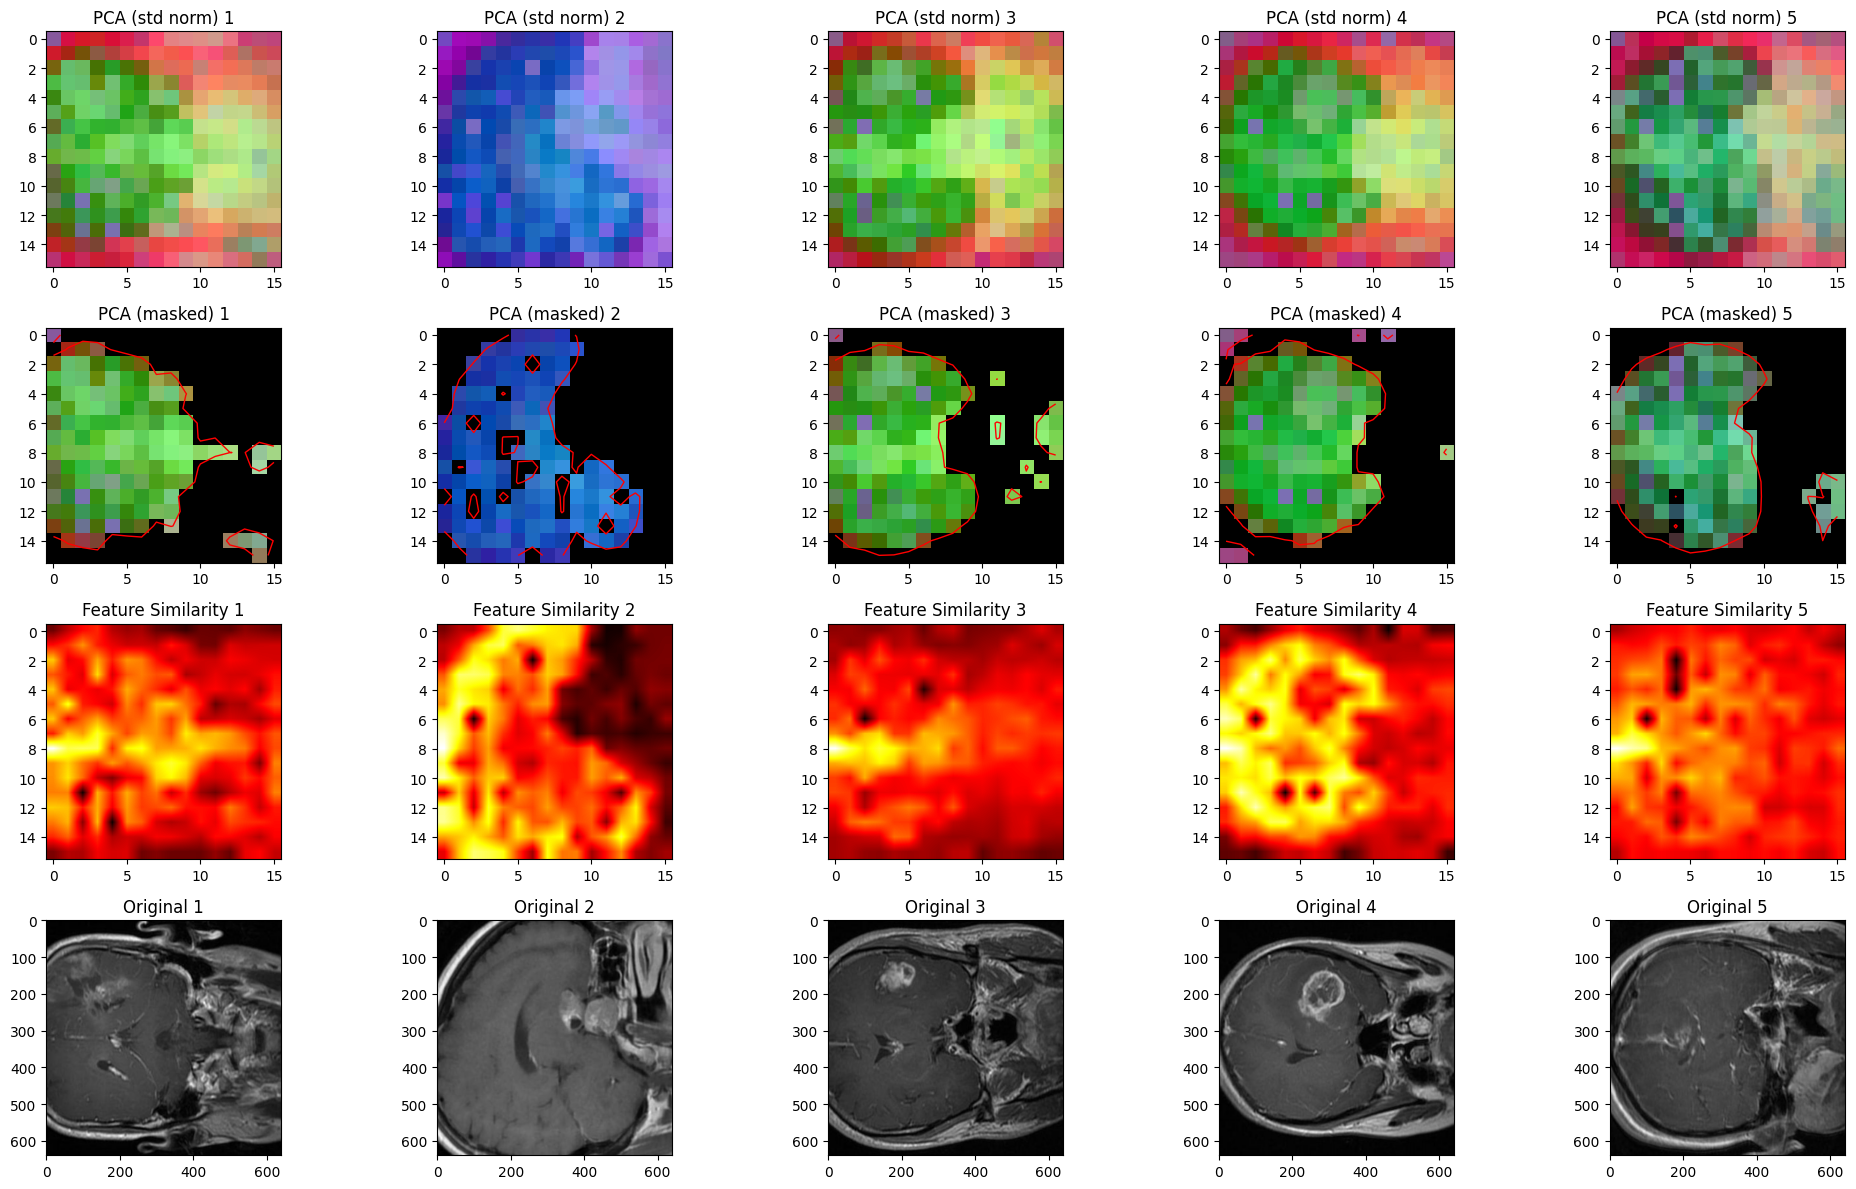

In [13]:
# Apply PCA to all patches
pca = decomposition.PCA(n_components=3)
all_pca = pca.fit_transform(all_patches)

# PCA variance
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Standardize PCA results and normalize to [0, 1]
all_pca_std = (all_pca - all_pca.mean(0)) / (all_pca.std(0) + 1e-8)
all_pca_std_norm = (all_pca_std - all_pca_std.min(0)) / (np.ptp(all_pca_std, axis=0) + 1e-8)

# Split back to images with improved normalization
num_patches_side = int(np.sqrt(num_patches))
pca_imgs_std = all_pca_std_norm.reshape(batch_size, num_patches, 3)
pca_imgs_std = pca_imgs_std.reshape(batch_size, num_patches_side, num_patches_side, 3)

# Apply adaptive background masking based on the first principal component
fig, axs = plt.subplots(4, batch_size, figsize=(4 * batch_size, 12))

for i in range(batch_size):
    # Compute adaptive threshold for background masking
    first_pc = pca_imgs_std[i][..., 0]
    threshold = np.percentile(first_pc, 50)  # Use 50th percentile as threshold

    # Apply background mask
    background_mask = first_pc > threshold
    pca_img_masked = pca_imgs_std[i].copy()
    pca_img_masked[background_mask] = 0

    # Compute cosine similarity between patch features
    image_patches = feature_maps[i]  # [num_patches, embed_dim]
    patches_norm = torch.nn.functional.normalize(image_patches, p=2, dim=1)
    similarity_matrix = torch.mm(patches_norm, patches_norm.T)

    # Use center patch as reference
    center_idx = similarity_matrix.shape[0] // 2
    center_similarities = similarity_matrix[center_idx, :]
    similarity_map = center_similarities.reshape(num_patches_side, num_patches_side)

    # Original PCA (no masking)
    axs[0, i].imshow(pca_imgs_std[i])
    axs[0, i].set_title(f"PCA (std norm) {i + 1}")

    # PCA with adaptive background masking
    axs[1, i].imshow(pca_img_masked)
    axs[1, i].set_title(f"PCA (masked) {i + 1}")
    axs[1, i].contour(first_pc, levels=[threshold], colors="red", linewidths=1)

    # Feature similarity
    axs[2, i].imshow(similarity_map.cpu().numpy(), cmap="hot", interpolation="bilinear")
    axs[2, i].set_title(f"Feature Similarity {i + 1}")

    # Original image
    axs[3, i].imshow(images[i])
    axs[3, i].set_title(f"Original {i + 1}")

plt.tight_layout()
plt.show()

## Setup dataset

In [ ]:
class CustomDataset(Dataset):
    """Simplified Dataset for object detection"""

    def __init__(self, directory: Path, processor=None) -> None:
        """
        Args:
            directory: Path to images and labels folder
            processor: Image processor (DINOv2 processor)
        """
        super().__init__()
        self.images_dir = directory / "images"
        self.labels_dir = directory / "labels"
        self.processor = processor

        # Get all image files
        self.image_files = list(self.images_dir.glob("*.jpg"))
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Dict[str, Any]:
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        label_path = self.labels_dir / f"{img_path.stem}.txt"
        labels = self._load_labels(label_path, image.size)

        # Process image
        if self.processor:
            processed_image = self.processor(images=image, return_tensors="pt")
            pixel_values = processed_image["pixel_values"].squeeze(0)
        else:
            pixel_values = image

        return {"pixel_values": pixel_values, "labels": labels, "image_path": str(img_path), "original_image": image}

    def _load_labels(self, labels_path: Path, image_size: Tuple[int, int]) -> List[Dict[str, Any]]:
        """Load labels from text file"""
        labels = []
        img_width, img_height = image_size

        with open(labels_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            entries = line.strip().split()
            # Extract class id (first entry)
            class_id = int(entries[0])

            # Extract polygon coordinates
            coordinates = [float(i) for i in entries[1:]]
            x_coords = [i * img_width for i in coordinates[::2]]
            y_coords = [i * img_height for i in coordinates[1::2]]

            # Get bounding box from polygon vertices
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Convert to center format
            cx = (x_min + x_max) / 2
            cy = (y_min + y_max) / 2
            width = x_max - x_min
            height = y_max - y_min

            labels.append(
                {"class_id": class_id, "bbox": [cx, cy, width, height], "vertices": list(zip(x_coords, y_coords))}
            )

        return labels

## Setup Dataloaders:

In [11]:
def create_dataloaders(
    train_dir: Path, test_dir: Path, processor, batch_size: int = 16
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = CustomDataset(train_dir, processor)
    test_dataset = CustomDataset(test_dir, processor)

    def collate_fn(batch) -> Dict[str, Any]:
        """Custom collate function to handle variable number of labels"""
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = [item["labels"] for item in batch]
        image_paths = [item["image_path"] for item in batch]
        original_images = [item["original_image"] for item in batch]

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "image_paths": image_paths,
            "original_images": original_images,
        }

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_dataloader, test_dataloader

In [12]:
train_dir = Path("../data/BrainTumor/train")
test_dir = Path("../data/BrainTumor/test")

# Create train and test dataloaders
train_dataloader, test_dataloader = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    processor=processor,
    batch_size=16,
)

print(f"Train dataloader: {len(train_dataloader)} batches")
print(f"Test dataloader: {len(test_dataloader)} batches")

# Visualize first train batch
for batch in train_dataloader:
    print(f"\nBatch pixel_values shape: {batch['pixel_values'].shape}")
    print(f"Batch labels: {batch['labels']}")
    break

# Print some statistics
print("\nDataset Statistics:")
total_images = 0
total_objects = 0
class_counts = {}

for batch in train_dataloader:
    labels_list = batch["labels"]
    total_images += len(labels_list)

    for labels in labels_list:
        total_objects += len(labels)
        for label in labels:
            class_id = label["class_id"]
            class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(f"Total training images: {total_images}")
print(f"Total objects: {total_objects}")
print(f"Average objects per image: {total_objects / total_images:.2f}")
print(f"Class distribution: {class_counts}")

# Test a single sample to see the data structure
print("\nSample data structure:")
sample = next(iter(train_dataloader))
print(f"Keys: {sample.keys()}")
print(f"Pixel values shape: {sample['pixel_values'].shape}")
print(f"Labels for first image: {sample['labels'][0]}")

Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images
Train dataloader: 134 batches
Test dataloader: 20 batches

Batch pixel_values shape: torch.Size([16, 3, 224, 224])
Batch labels: [[{'class_id': 0, 'bbox': [194.317549, 254.930362, 379.721448, 431.420613], 'vertices': [(294.150418, 256.713092), (267.409471, 254.930362), (244.233983, 270.97493), (228.189415, 324.456825), (194.317549, 390.417827), (197.883008, 413.593315), (228.189415, 431.420613), (269.192201, 429.637883), (335.15320299999996, 385.069638), (379.721448, 344.066852), (376.155989, 311.977716), (356.545961, 285.236769), (294.150418, 256.713092)]}], [{'class_id': 0, 'bbox': [192.534819, 212.144847, 317.325905, 310.194986], 'vertices': [(262.061281, 213.927577), (231.754875, 212.144847), (208.579387, 222.841226), (196.100279, 240.668524), (192.534819, 281.671309), (203.231198, 303.064067), (246.01671299999998, 310.194986), (306.629526, 299.498607), (315.543175, 287.019499), 

Testing DataLoader...
Batch shape: torch.Size([16, 3, 224, 224])
Original images shape: [640, 640]


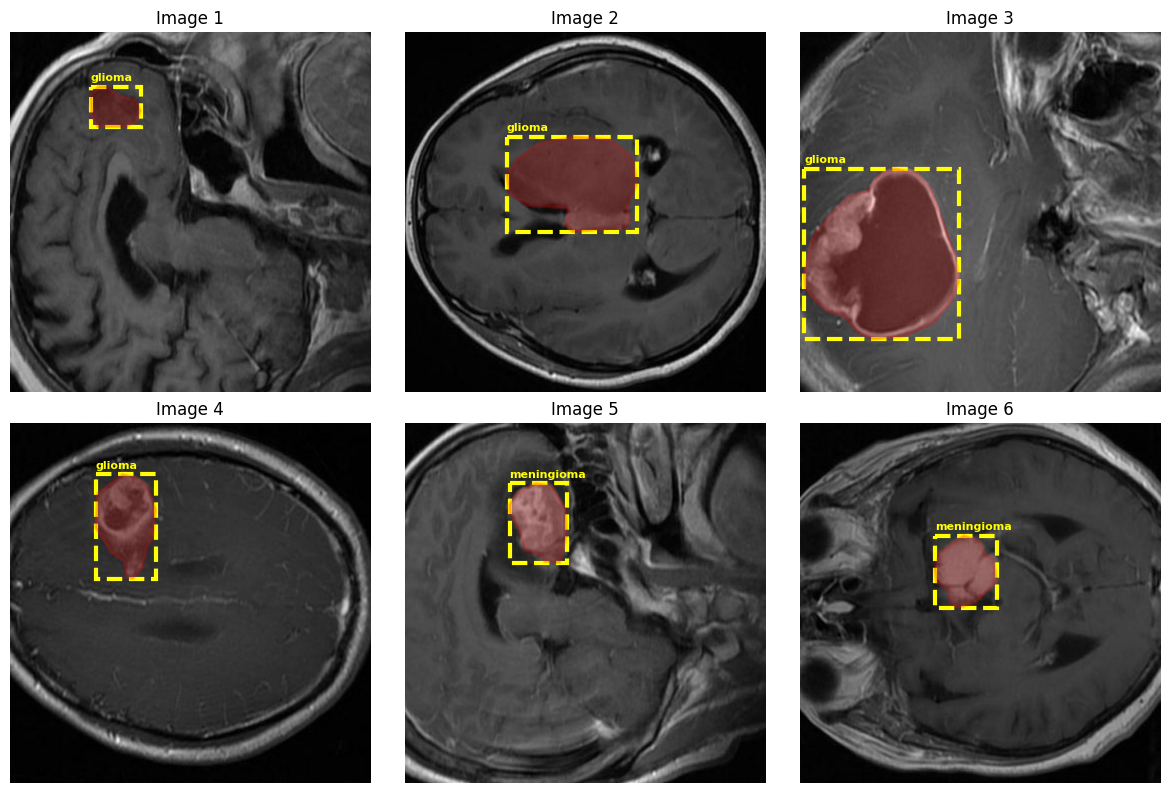

In [13]:
def visualize_batch(dataloader, num_samples=6) -> None:
    """Visualize a batch of images with YOLO bounding boxes"""

    # Get one batch
    batch = next(iter(dataloader))

    pixel_values = batch["pixel_values"]
    labels_list = batch["labels"]
    original_images = batch["original_images"]

    print(f"Batch shape: {pixel_values.shape}")
    print(f"Original images shape: {F.get_size(original_images[0])}")

    # Plot images with bounding boxes
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(min(num_samples, len(original_images))):
        ax = axes[i]
        image = original_images[i]
        labels = labels_list[i]

        # Display image
        ax.imshow(image)
        ax.set_title(f"Image {i + 1}")
        ax.axis("off")

        # Draw bounding boxes
        for label in labels:
            bbox = label["bbox"]
            polygon_points = label["vertices"]
            class_id = label["class_id"]

            # Create rectangle patch
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min

            # Draw both polygon and bounding box
            rect = patches.Rectangle(
                (x_min, y_min), width, height, linewidth=3, edgecolor="yellow", facecolor="none", linestyle="--"
            )
            polygon = patches.Polygon(
                polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True
            )
            ax.add_patch(rect)
            ax.add_patch(polygon)

            # Add class label
            ax.text(x_min, y_min - 10, f"{CLASSES_NAMES[class_id]}", color="yellow", fontsize=8, fontweight="bold")

    plt.tight_layout()
    plt.show()


# Test the dataloader
print("Testing DataLoader...")
visualize_batch(train_dataloader)

## Training Loop:

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(
    model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device: torch.device
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Set model to device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device
        )
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results